# Приоритезация гипотез и проведение A/B теста интернет-магазина

# Задача :
 * Произвести приоритезацию списка гипотез для увеличения прибыли
 * На основании приоритезированного списка провести A/B-тест проанализировать результаты

## Загрузка данных и подготовка их к анализу

###  Загрузка файлов и импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math 
import datetime as dt
import scipy.stats as stats
import seaborn as sns
from scipy import stats as st
import random
from datetime import datetime, timedelta
pd.set_option('display.max_columns', 40)

In [2]:
import matplotlib.pyplot as plt

In [3]:
try:
    hypothesis, orders, visitors = ( 
        pd.read_csv('hypothesis.csv'), # список гипотез
        pd.read_csv('orders.csv'), # журнал покупок
        pd.read_csv('visitors.csv'),  # траты на рекламу
    
    )
except:
    hypothesis, orders, visitors = ( 
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'),
    )

### Знакомство с данными и предобработка

In [4]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


* Hypothesis - краткое описание гипотезы
* Reach - охват пользователей по 10-балльной шкале
* Impact - влияние на пользователей по 10-балльной шкале
* Confidence - уверенность в гипотезе по 10-балльной шкале
* Efforts - затраты ресурсов на проверку гипотезы по 10-балльной шкале. 

In [6]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


* transactionId - индификатор заказа
* visitorId - индикатор пользователя совершившего заказ
* date - дата, когда был совершен заказ
* revenue - выручка заказа
* group - группа A/B-теста , в которую попал заказ

In [8]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [9]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


* date -дата
* group - группа A/B-тестов
* visitors - количество пользователей в указанную дату в указанной группе A/B-теста 

In [11]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [13]:
# Проверим сколько юзеров есть встречаются в двух группах сразу и узнаем их ID
bad_visitors = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index()
bad_visitors = bad_visitors.query('group >= 2')['visitorId']
len(bad_visitors)

58

In [14]:
# отфильруем только заказы 'плохих' пользователей
orders_bad_visitors = orders[orders['visitorId'].isin(bad_visitors)]
# сгруппируем эти заказы
count_orders_bad_visitors = orders_bad_visitors.groupby(['date', 'group']).agg({'revenue': 'count'}).reset_index()
# соединим таблицу общего количества визитов по группам и количиество визитов плохих пользователей по группе и дате
visitors = visitors.merge(count_orders_bad_visitors, how='left', on=['date', 'group'])
visitors = visitors.fillna(value={'revenue' : 0})
visitors['visitors'] = visitors['visitors'] - visitors['revenue']
visitors['visitors'] = visitors['visitors'].astype('int64')
visitors.drop('revenue', axis=1, inplace=True)
visitors

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,712
4,2019-08-05,A,753
...,...,...,...
57,2019-08-27,B,715
58,2019-08-28,B,648
59,2019-08-29,B,526
60,2019-08-30,B,487


In [15]:
# удаляем заказы пользователей которые засветились в двух группах
orders = orders[~(orders['visitorId'].isin(bad_visitors))]

In [16]:
orders.rename(columns={'transactionId': 'orders', 'visitorId': 'buyers'}, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Вывод:
* Попусков в данных нет
* Произведена замена типа данных столбцов содержащих дату с object на datetime

## Приоритезация гипотез

### Приоритезация гипотез с помощью фреймворка ICE

Формула для расчета фреймворка ICE: 
$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [17]:
hypothesis['ICE'] = hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
print(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                          Hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000


### Приоритезация гипотез с помощью фреймворка RICE

Формула для расчета фреймворка RICE: 
$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

In [18]:
hypothesis['RICE'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts']
print(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


In [19]:
pd.set_option("display.max_colwidth", None)
display(hypothesis.sort_values(by=['RICE', 'ICE'], ascending=[False, False]))
pd.reset_option("display.max_colwidth") 

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


### Вывод

При использовании метода приотезации гипотез ICE на первом место выходит гипотиза под номером 8 тогда как при методе RICE она лишь в середине списка. Все по причини низкого охвата аудитории при использовании этого метода. При использовании же метода RICE приоритетное право проверки занимает гипотиза под номером 7 а в методе ICE она занимает 3 строчку. Если есть дополнительный параметр Reach  с достоверной оценкой охвата аудитории лучше всего использовать метод RICE так как этот метод может показать более точную картину по приоритезации в виду большего количества используемых переменных

## Анализ A/B-теста

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [21]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'orders' : 'nunique', 'buyers' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [22]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [23]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

### Анализ графика кумулятивной выручки по группам

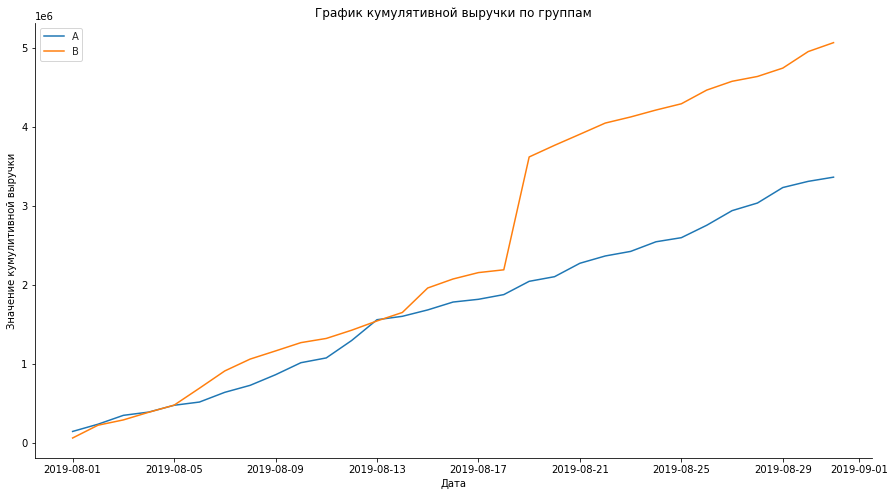

In [25]:
plt.figure(figsize=(15, 8)) 
ax = sns.lineplot(data=cumulativeData, x="date", y="revenue", hue='group')
sns.set_style('whitegrid') 
ax.set_xlabel('Дата')
ax.set_ylabel('Значение кумулитивной выручки')
ax.set_title("График кумулятивной выручки по группам")
ax.legend()
sns.despine()

Занчение выручки равномерно увиличивается во время всего теста что является хорошим знаком. С 18 по 19 число происходит резкий рост выручки в группе B что возможгно происходит по причине резкого увеличения количества заказов либо о появлении очень дорогих заказов в выборке (выбросы).

### Анализ графика кумулятивного среднего чека по группам

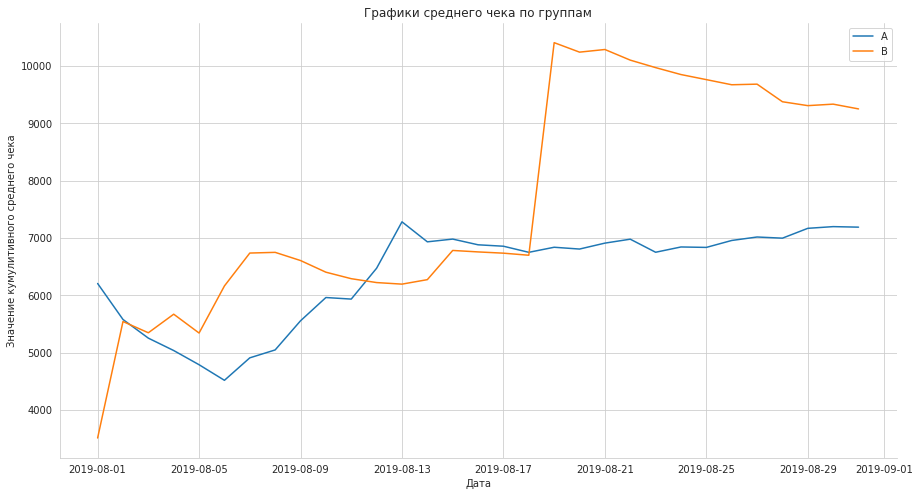

In [26]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x=cumulativeData["date"], y=cumulativeData["revenue"]/cumulativeData["orders"], hue=cumulativeData['group'])
sns.set_style('whitegrid') 
ax.set_xlabel('Дата')
ax.set_ylabel('Значение кумулитивного среднего чека')
ax.set_title("Графики среднего чека по группам")
ax.legend()
sns.despine()

Средний чек становится равномерным ближе к концу теста у группы А. А вот в группе B происходит реский всплеск значения среднего чека в районе 18 августа и потом идет на снижение скорее всего этот всплеск связан с болшим заказом и чтобы снова стать равномерным  нужно больше данных чтобы прийти к реальному среднему чеку и установится на его уровне

###  Анализ графика относительного изменения кумулятивного среднего чека группы B к группе A

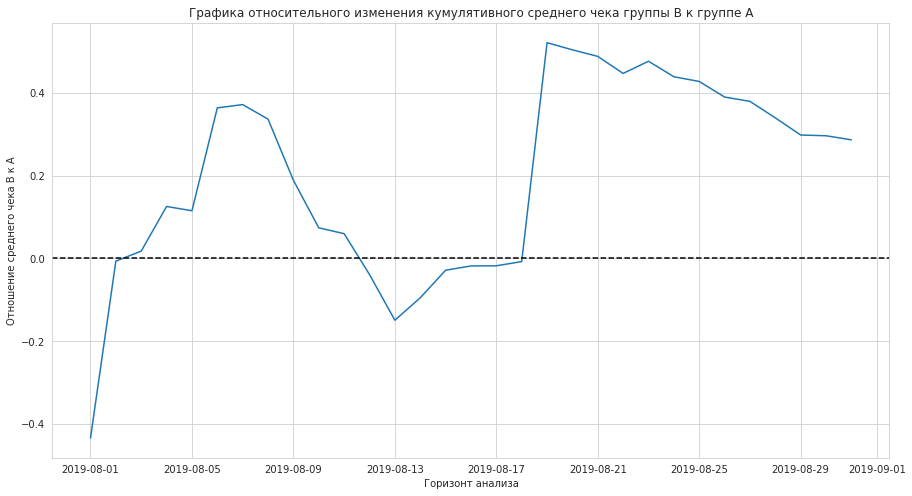

In [27]:
plt.figure(figsize=(15, 8))
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Отношение среднего чека B к А')
plt.xlabel('Горизонт анализа')
plt.title('Графика относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

Можно сказать что график относительного изменения кумулятивного среднего чека группы B к группе A в некоторых местах скачет возможно это связано с крупными заказами  которые формируют выбросы. Резкие скачки с 8 по 13 и с 18 пл 19 числа.

### Анализ  графика кумулятивной конверсии по группам

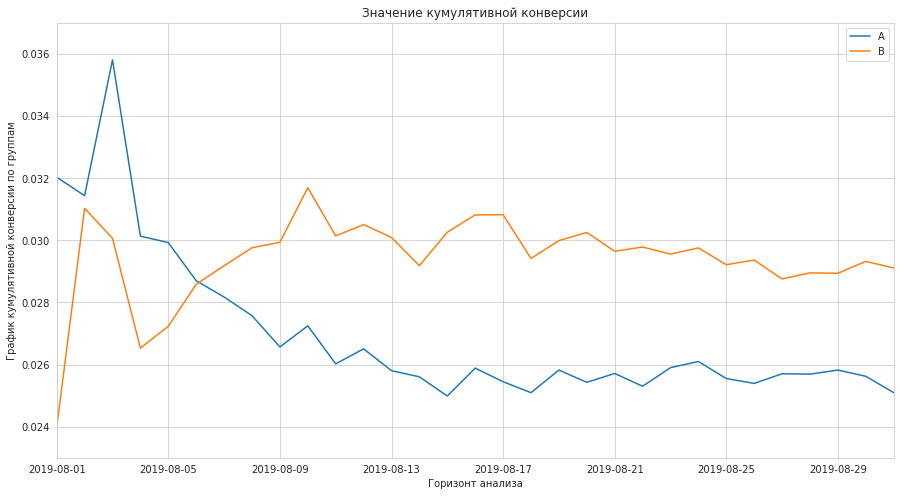

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15, 8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
plt.axis([cumulativeDataA['date'].min(), cumulativeDataA['date'].max(), 0.023, 0.037])
plt.ylabel('График кумулятивной конверсии по группам')
plt.xlabel('Горизонт анализа')
plt.title('Значение кумулятивной конверсии')
plt.show()

На 14 день конверсия группы В первый раз достигает среднего значения и далее дигается вдоль нее. По началу наблюдалась сльная волотильность по этой группе. В группе А в начале наблюдается всплеск значения на 3 день но дальшее уже идет снижение значения до среднего которое в первый раз достигается 16 числа и далее в основно показатели приближены к нему

###  Анализ графика относительного изменения кумулятивной конверсии группы B к группе  А

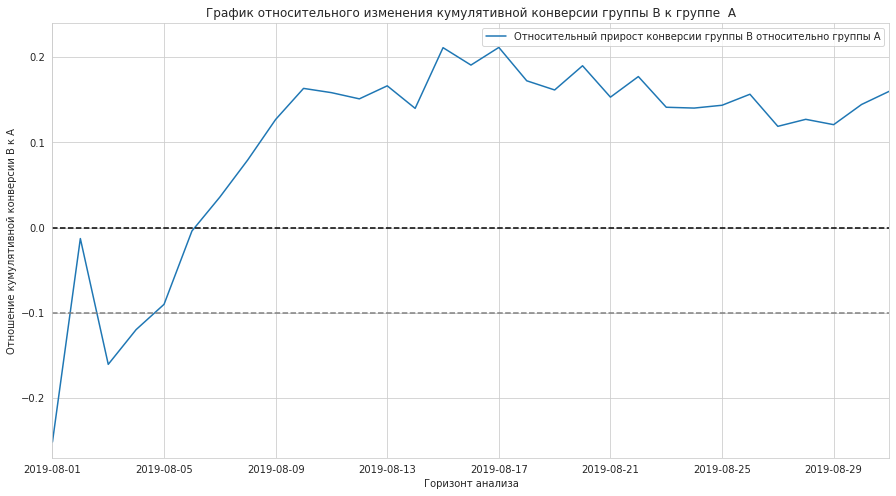

In [29]:
plt.figure(figsize=(15, 8))
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([cumulativeDataA['date'].min(), cumulativeDataA['date'].max(), -0.27, 0.24])
plt.ylabel('Отношение кумулятивной конверсии В к А')
plt.xlabel('Горизонт анализа')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе  А')
plt.show()

С 2 на 3 день можно видеть что конверсия стала в группе А больше чем в группе В но далее отношение конверсии в пользу группы В сохраналась на всем промежутке эсперемента с возможным средним в районе 0.13 Под конец теста видно что разница между конверсиями начинает расти в пользу В группы тестируемых.

###  Анализ точечного графика количества заказов по пользователям

In [30]:
ordersByUsers = orders.groupby('buyers',  as_index=False).agg({'orders' : 'nunique'})
ordersByUsers.columns = ['buyers', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

         buyers  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


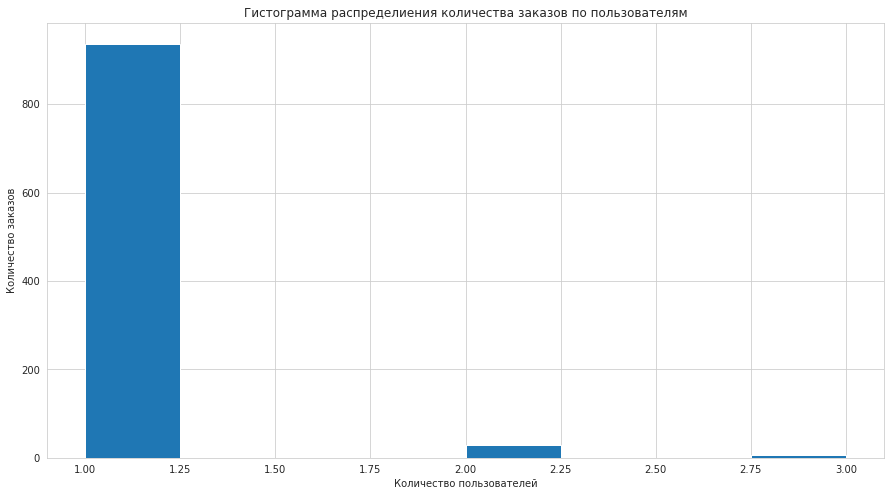

In [31]:
plt.figure(figsize=(15, 8))
plt.hist(ordersByUsers['orders'], bins=8)
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.title('Гистограмма распределиения количества заказов по пользователям')
plt.show()

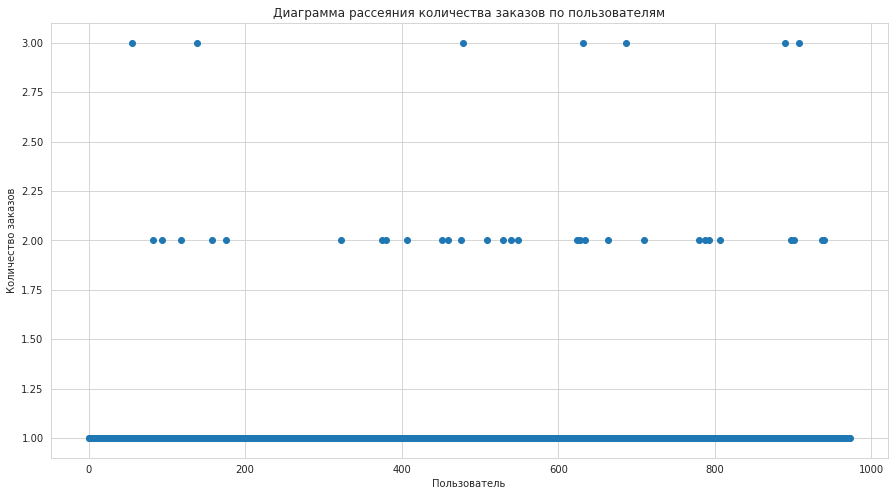

In [32]:
plt.figure(figsize=(15, 8))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('Количество заказов')
plt.xlabel('Пользователь')
plt.title('Диаграмма рассеяния количества заказов по пользователям')
plt.show()

В основном люди делали по 1-2 заказа. По графику можно сказать что есть определенное количество людей которые совершили и 3 заказа которые можно будет считать как выбросы и отфильтровать их в последствии но для начала нужно определить 95 и 99-й перцентили.

In [33]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


Не более 5% пользователей оформляли больше чем 1 заказ. И 1% пользователей заказывали более 2 раз.
Разумно выбрать 2 или 4 заказов на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

###  Анализ точечного графика стоимости заказа по пользователям

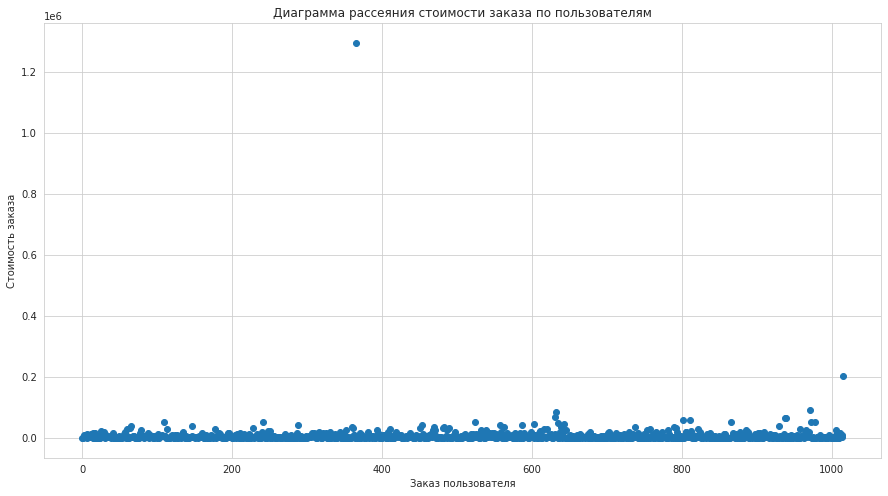

In [34]:
plt.figure(figsize=(15, 8))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость заказа')
plt.xlabel('Заказ пользователя')
plt.title('Диаграмма рассеяния стоимости заказа по пользователям')
plt.show()

По большей части стоимости заказов одинаковы и формирубт между собой прямую линию, но так же по графику отчеливо видны значения которые сильно выбиваеются из общей массы и могут существенно повлиять на расчет статистической значимости в последстивии.

In [35]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов стоит больше 26785. И 1% заказов стоит больше 53904.
Разумно выбрать 26785 за границу стоимости заказа, и отсеивать аномальные заказы по ней. 

### Расчет статистической значимости различий в конверсиях между группами по «сырым» данным

Сформулируем гипотезы:
* Нулевая: различий в конверсии между группами нет. 
* Альтернативная: различия в конверсии между группами есть.

Уровень значимости примем равный alpha = 0.05

In [36]:
# количество пользователей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
# количество пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
# количество пользователей в выбранную дату в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
# количество пользователей до выбранной даты включительно в группе В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
# количество заказов и  суммарная выручка в выбранную дату в группе A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orders', 'buyers', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orders': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
# суммарное число заказов и суммарная выручка до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
# количество заказов и  суммарная выручка в выбранную дату в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orders', 'buyers', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orders': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
# суммарное число заказов и суммарная выручка до выбранной даты включительно в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
# получпение общей таблицы 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)



In [37]:
# число уникальных заказов свершенных пользователями в разбивке по группам
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('buyers', as_index=False)
    .agg({'orders': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('buyers', as_index=False)
    .agg({'orders': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


0.011
0.160


Вывод: 
* p-value = 0.011 а это значит что стастистически значемые различия между значениями есть и можно отвергнуть нулевую гипотезу.
* конверсия в группе В на 16% больше чем в группе А

### Расчет  статистической значимости  в средних чеках заказа между группами по «сырым» данным

 Формулировка гипотез:
* Нулевая гипотеза: различий в среднем чеке между группами нет. 
* Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [38]:
# рассчет статистической значимости различий в среднем чеке между группами
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# расчет относительного различия между группами
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


Вывод: 
* P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет 
* Средний чек группы B значительно выше среднего чека группы A

### Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

Отфильтруем покупателей кто совершил больше 4 заказов или совершил заказ дороже 28 000 рублей

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['buyers']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
(58,)


Всего 59 пользователей которые вышле за выбранные пределы которые считаются выбросами.

In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.012
0.182


После проведения расчета статистической значимости конверсии уже на отфильтрованных от выбросов значений можно сказать следущее:
* Значения уровня значимости  почти такие же как и на сырых данных
* P-value меньше 0.05 а это значит что можно отвергнуть нулевую гипотезу как и на сырых данных
* На очищенных данных конверсия в группе В уже на 18.2% больше чем в группе А

### Расчет статистичесой значимости различий в среднем чеке заказа между группами по «очищенным» данны

In [41]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['buyers'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['buyers'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['buyers'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['buyers'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.646
-0.048


После проведения расчета статистической значимости среднего чека заказа уже на отфильтрованных от выбросов значений можно сказать следущее:
* P-value = 0.646 что является намного больше 0.05 а это значит что нельзя отвергнуть нулевую гипотезу как и на сырых данных
* Разница между сегментами поменялась и теперь группа А показывает на 5% результат лучше группы В

## Вывод

Вывод по приоритезации гипетез:
* В приоритете гипотеза номер 7 так как показала лучшие результаты  в каждом из методов.

Вывод по AB-тесту:
* Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий
* После фильтрации разница между сигментами еще больше увеличилась
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A и нет значительной тенденции к обратному
* График различия среднего чека говорит о том, что результаты группы B лучше на 27% но есть тенденция на ухудшение
* Исходя из приведенных выше фактов считаю что можно остановить тест и зафиксировать победу группы B